In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from datetime import datetime
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from feature_engine.creation import  CyclicalFeatures
from feature_engine.timeseries.forecasting import LagFeatures, WindowFeatures

from xgboost import XGBRegressor
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import kaleido
import plotly.io as pio
import scipy.stats as stats
import tensorflow as tf
from xgboost import DMatrix
import shap

In [2]:
plot_folder = '/Users/eddie/cs163/src/Plots'
data_folder = '/Users/eddie/cs163/src/Data'
pio.renderers.default = 'png'

def replace_with_underscore(x):
    return x.replace(' ', '_')
    

In [3]:
df = pd.read_csv('/Users/eddie/cs163/src/Data/final.csv', index_col=['DATE'], parse_dates=['DATE'], )
df = df.asfreq('MS')
df['month'] = df.index.month
df['year'] = df.index.year
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2005-01-01 to 2024-08-01
Freq: MS
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Food and Beverages CPI (target)                  236 non-null    float64
 7   Civilian workers Total compensation              236 non-null    float64
 8   Private industry workers Total compensation      236 non-null    float64
 9   Stat

In [4]:
Y = df.iloc[:, 6]
X = df[[c for c in df.columns if c not in ['Food and Beverages CPI (target)']]]

In [5]:
np.mean(X.iloc[0,:])

153.67642857142857

### Averaging and getting the mean of each index

In [6]:
def mean_index(data, name):
    nrow, ncol = data.shape
    avg = []
    for row in range(nrow):
        avg.append(np.mean(data.iloc[row,:]))
    return pd.Series(avg, index=data.index, name=name)

mean_only_X = pd.DataFrame(index=X.index)
# mean_only_X['PPI'] = mean_index(X.iloc[:,:6], 'PPI')
mean_only_X[X.iloc[:,:6].columns] = X.iloc[:,:6]
mean_only_X['CE'] = mean_index(X.iloc[:,6:9], 'CE')
mean_only_X['RPI'] = mean_index(X.iloc[:,9:], 'RPI')
mean_only_X['Electricity Price'] = mean_index(X.iloc[:,18:21], 'Electricity Price')
mean_only_X['Gas Price'] = X['Gas Price']

diff_mean_only_X = pd.DataFrame(index=X.index)
# diff_mean_only_X['PPI'] = mean_index(X.iloc[:,:6], 'PPI').diff()
diff_mean_only_X[X.iloc[:,:6].columns] = X.iloc[:,:6].diff()
diff_mean_only_X['CE'] = mean_index(X.iloc[:,6:9], 'CE').diff()
diff_mean_only_X['RPI'] = mean_index(X.iloc[:,9:], 'RPI').diff()
diff_mean_only_X['Electricity Price'] = mean_index(X.iloc[:,18:21], 'Electricity Price').diff()
diff_mean_only_X['Gas Price'] = X['Gas Price'].diff()
diff_mean_only_X.dropna(inplace=True)

diff_y = Y.diff()
diff_y.dropna(inplace=True)

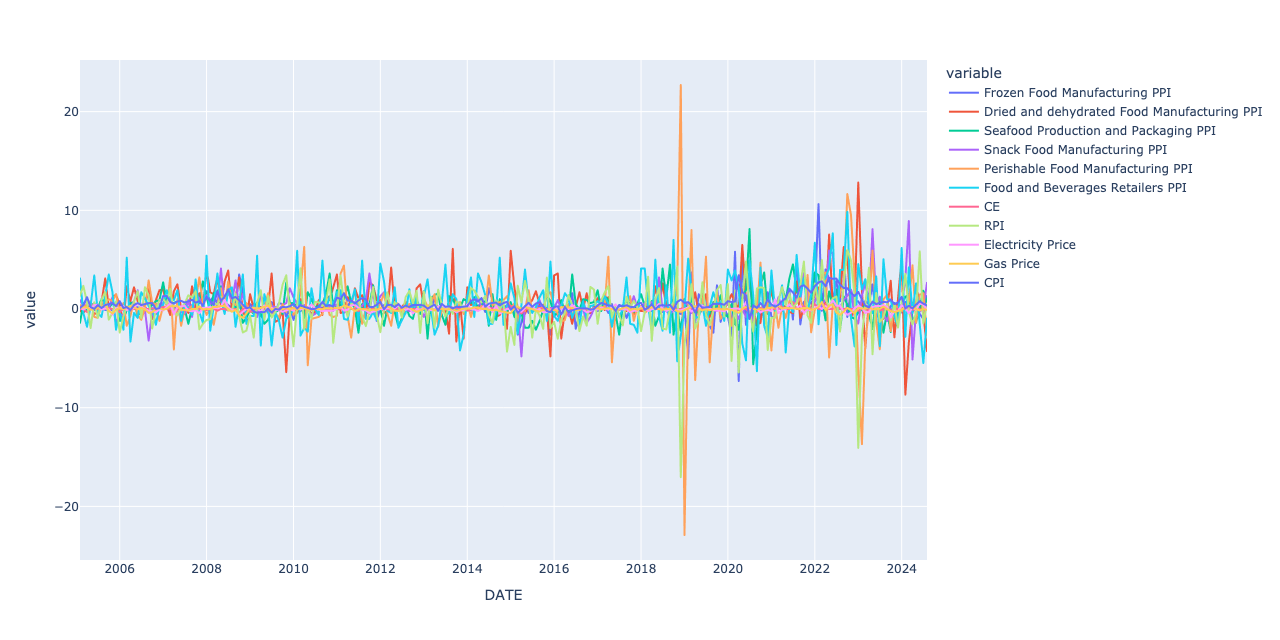

In [7]:
diff_mean_only_df = diff_mean_only_X.iloc[:,:]
diff_mean_only_df['CPI'] = diff_y
px.line(diff_mean_only_df, width=1280, height=640)

In [8]:
mean_only_df_vif = diff_mean_only_df # Adds intercept

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = mean_only_df_vif.columns
vif_data['VIF'] = [variance_inflation_factor(mean_only_df_vif.values, i) for i in range(mean_only_df_vif.shape[1])]
vif_data

,Variable,VIF
0,Frozen Food Manufacturing PPI,1.232552
1,Dried and dehydrated Food Manufacturing PPI,1.387089
2,Seafood Production and Packaging PPI,1.215888
3,Snack Food Manufacturing PPI,1.231758
4,Perishable Food Manufacturing PPI,1.067939
5,Food and Beverages Retailers PPI,1.142272
6,CE,1.085985
7,RPI,1.180559
8,Electricity Price,1.109627
9,Gas Price,1.157441


In [9]:
for column in diff_mean_only_X.columns:
    print(column , ' :', stats.shapiro(diff_mean_only_X[column]))

Frozen Food Manufacturing PPI  : ShapiroResult(statistic=0.7326894551886755, pvalue=3.4565053647348475e-19)
Dried and dehydrated Food Manufacturing PPI  : ShapiroResult(statistic=0.8365219918597775, pvalue=5.141468716660006e-15)
Seafood Production and Packaging PPI  : ShapiroResult(statistic=0.9527796076183269, pvalue=6.012654370205769e-07)
Snack Food Manufacturing PPI  : ShapiroResult(statistic=0.7057086770584114, pvalue=4.5446400056928515e-20)
Perishable Food Manufacturing PPI  : ShapiroResult(statistic=0.6458799005682461, pvalue=7.97172335169679e-22)
Food and Beverages Retailers PPI  : ShapiroResult(statistic=0.9844788172600474, pvalue=0.011468321087542177)
CE  : ShapiroResult(statistic=0.6670475077549789, pvalue=3.1272582636715557e-21)
RPI  : ShapiroResult(statistic=0.8443015669176146, pvalue=1.2429423937139682e-14)
Electricity Price  : ShapiroResult(statistic=0.9788379020072603, pvalue=0.0013787618681688294)
Gas Price  : ShapiroResult(statistic=0.9551356166014994, pvalue=1.0871824

### KNN Imputation for Fish Food and Horticulture

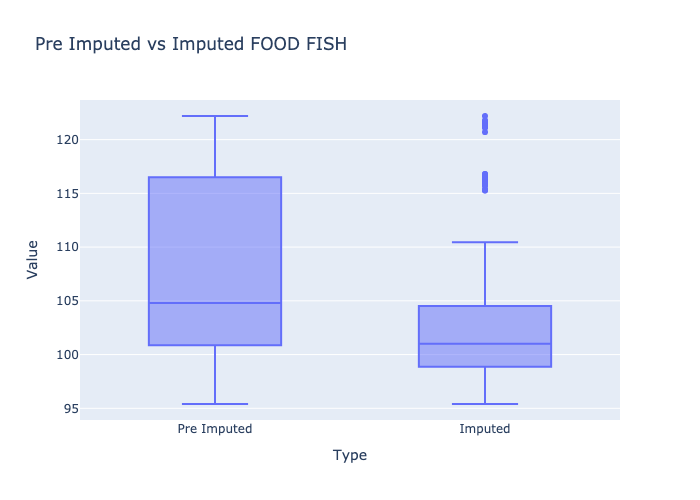

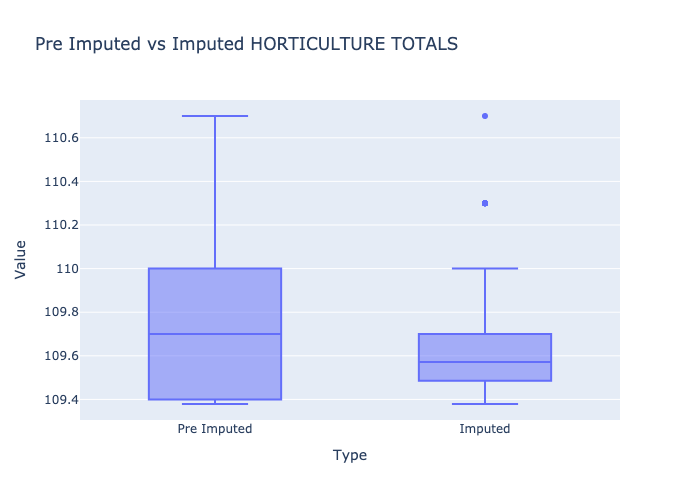

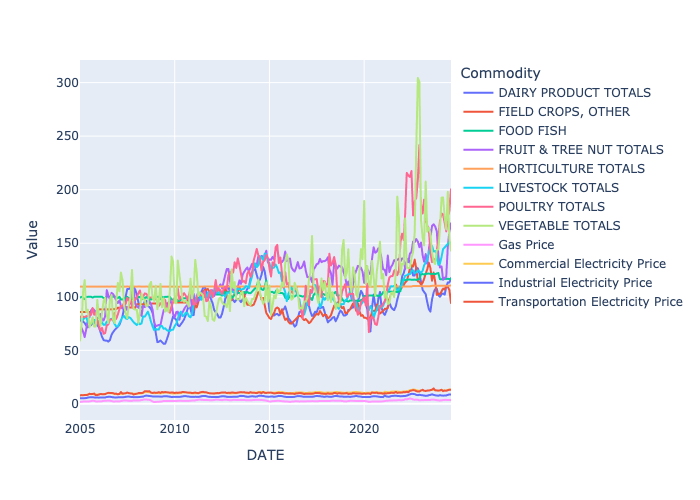

In [10]:
imputer = KNNImputer(n_neighbors=7)
# scaler = StandardScaler()
RPI_df = X.iloc[:,9:-2]
# RPI_df = pd.DataFrame(scaler.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)
RPI_df_imputed = pd.DataFrame(imputer.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)

for column in ['FOOD FISH', 'HORTICULTURE TOTALS']:
    data = pd.DataFrame({
        'Pre Imputed': RPI_df[column], 
        'Imputed': RPI_df_imputed[column]
    }, index=X.index)
    data_melted = data.melt(var_name='Type', value_name='Value', ignore_index=False)
    fig = px.box(data_melted, title='Pre Imputed vs Imputed ' + column, x = 'Type', y = 'Value')
    fig.write_image(os.path.join(plot_folder,'KNN_Imputed_boxplot_for_' + replace_with_underscore(column) + '.png'), width=1280, height=640)
    fig.show()
    
RPI_df_imputed_melted = RPI_df_imputed.melt(value_name='Value', var_name='Commodity', ignore_index=False)
# RPI_df_imputed_melted = RPI_df_imputed_melted[RPI_df_imputed_melted['Commodity'].isin(['FOOD FISH', 'HORTICULTURE TOTALS'])]
fig = px.line(RPI_df_imputed_melted, x=RPI_df_imputed_melted.index, y='Value', color='Commodity')
fig.write_image(os.path.join(plot_folder,'Imputed_RPI_timeseries.png'), width=1280, height=640)
fig.show()

After the imputation, the data for FOOD FISH and HORTICULTURE appear to maintain the normal distribution but have new outliers. However, based on the timeseries line plot with other commodities RPI, the outliers are reasonable because other indices also have strong outliers at these periods. So, we can use the imputed data for further analysis.

In [11]:
# Update newly imputed values
X.update(RPI_df_imputed)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2005-01-01 to 2024-08-01
Freq: MS
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Civilian workers Total compensation              236 non-null    float64
 7   Private industry workers Total compensation      236 non-null    float64
 8   State and government workers Total compensation  236 non-null    float64
 9   DAIR

#### Consumer Expenditures Imputation

Since CE data is 2 months behind others, we will also use KNN Imputation to fill the missing value for them. Notes that this is only 2/236 so it should not affect the distribution.

In [12]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2005-01-01 to 2024-08-01
Freq: MS
Data columns (total 23 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Civilian workers Total compensation              236 non-null    float64
 7   Private industry workers Total compensation      236 non-null    float64
 8   State and government workers Total compensation  236 non-null    float64
 9   DAIR

# Timeseries features engineering

## Feature lags
### Define function

In [1]:
def create_lag_features(df, lags, features= []):
    lag_f = LagFeatures(periods=lags)
    if isinstance(df, pd.Series):
        res_df = lag_f.fit_transform(pd.DataFrame(df)).iloc[:,1:]
        return res_df
    elif isinstance(df, pd.DataFrame):
        res_df = lag_f.fit_transform(df[features]).iloc[:,len(features):]
        return res_df

### Feature selection using Cross-correlation plot

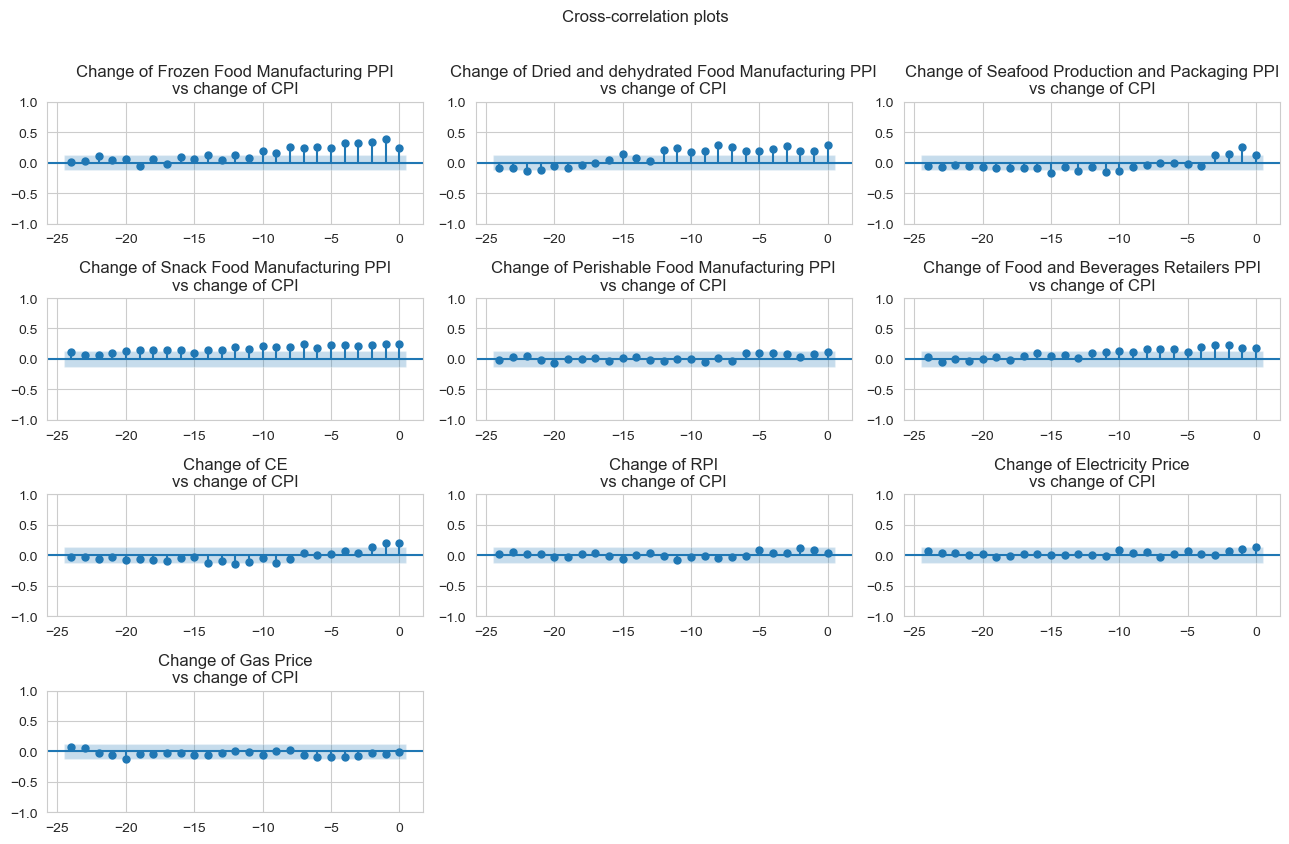

In [14]:
features = diff_mean_only_X.columns
nrow = 4
ncol = 3

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(13,8))

# Flatten the axs array for easier indexing in a loop
axs = axs.flatten()

for i in range(len(features)):
    plot_ccf(diff_mean_only_X[features[i]], diff_y, title='Change of ' + features[i] + '\nvs change of CPI', ax=axs[i], negative_lags=True, alpha=0.05)

# Hide any unused subplots if there are fewer features than subplots
for j in range(len(features), len(axs)):
    axs[j].set_visible(False)

# plt.suptitle('Cross-correlation plots of the changes of all variables to changes of CPI')
plt.tight_layout()
plt.suptitle('Cross-correlation plots', y=1.05)
plt.savefig(os.path.join(plot_folder, 'CCF_of_diff_features_vs_diff_CPI.png'))
plt.show()

In [15]:
def find_best_lag_of_columns(data, target):
    result = []
    
    for column in data.columns:
        tmp = []
        # Calculate cross-correlation
        res = ccf(data[column], target, nlags=9)
        
        # Linear search for significant lags (cut-off at 95% confidence level)
        for i in range(1, len(res)):
            if np.abs(res[i]) > 0.05:
                tmp.append(i)
            else:
                 break
        if len(tmp) > 0:
            result.append(tmp)
        
    return result, data.columns[:len(result)]

In [16]:
res, cols = find_best_lag_of_columns(diff_mean_only_X.iloc[:, :-1], diff_y)
for i in range(len(cols)):
    tmp = create_lag_features(diff_mean_only_df[cols[i]], lags=res[i])
    diff_mean_only_X[tmp.columns] = tmp
diff_mean_only_X

,Frozen Food Manufacturing PPI,Dried and dehydrated Food Manufacturing PPI,Seafood Production and Packaging PPI,Snack Food Manufacturing PPI,Perishable Food Manufacturing PPI,Food and Beverages Retailers PPI,CE,RPI,Electricity Price,Gas Price,...,Food and Beverages Retailers PPI_lag_5,Food and Beverages Retailers PPI_lag_6,Food and Beverages Retailers PPI_lag_7,Food and Beverages Retailers PPI_lag_8,CE_lag_1,CE_lag_2,RPI_lag_1,RPI_lag_2,Electricity Price_lag_1,Electricity Price_lag_2
DATE,,,,,,,,,,,,,,,,,,,,,
2005-02-01,-0.100,-0.200,-1.400,0.900,0.400,3.100,0.000000,1.361500,0.153333,0.078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-01,0.000,-0.400,0.600,0.300,0.100,-0.400,0.000000,2.353083,-0.043333,0.167,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.361500,NaN,0.153333,NaN
2005-04-01,0.100,0.100,-0.100,1.100,0.500,-1.800,-0.300000,0.672083,0.133333,0.165,...,NaN,NaN,NaN,NaN,0.000000,0.000000,2.353083,1.361500,-0.043333,0.153333
2005-05-01,0.300,0.400,0.300,0.400,0.800,0.300,0.000000,-1.931667,0.066667,-0.080,...,NaN,NaN,NaN,NaN,-0.300000,0.000000,0.672083,2.353083,0.133333,-0.043333
2005-06-01,-0.100,-0.500,0.600,0.500,-0.800,3.400,0.000000,0.681917,0.396667,-0.007,...,NaN,NaN,NaN,NaN,0.000000,-0.300000,-1.931667,0.672083,0.066667,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.389,-0.160,-0.946,-5.111,4.431,-0.404,-0.066667,-1.572071,0.166667,0.191,...,-0.744,0.948,0.996,5.040,0.000000,0.000000,-0.241143,3.565786,-0.430000,0.096667
2024-05-01,0.730,2.427,-1.400,-0.199,-1.375,2.598,0.000000,-0.383429,-0.086667,-0.008,...,-1.814,-0.744,0.948,0.996,-0.066667,0.000000,-1.572071,-0.241143,0.166667,-0.430000
2024-06-01,-0.516,0.543,0.125,-0.238,1.467,-1.544,0.000000,5.842214,0.546667,-0.149,...,6.183,-1.814,-0.744,0.948,0.000000,-0.066667,-0.383429,-1.572071,-0.086667,0.166667


The plots shows that the changes of PPI indices (except Perishable Food), and CE indices from previous lags has significant impacts on CPI. So, we will create lags features accordingly

## Cyclical features

In [17]:
def cyclical_features(df, features):
    cycler = CyclicalFeatures()
    return cycler.fit_transform(df[features]).iloc[:,2:]

In [18]:
time_features = ['month', 'year']
diff_mean_only_X['month'] = diff_mean_only_X.index.month
diff_mean_only_X['year'] = diff_mean_only_X.index.year
cyc_data = cyclical_features(diff_mean_only_X, time_features)
diff_mean_only_X[cyc_data.columns] = cyc_data
# diff_mean_only_X.drop(columns=['year'], inplace=True)

In [19]:
diff_mean_only_X

,Frozen Food Manufacturing PPI,Dried and dehydrated Food Manufacturing PPI,Seafood Production and Packaging PPI,Snack Food Manufacturing PPI,Perishable Food Manufacturing PPI,Food and Beverages Retailers PPI,CE,RPI,Electricity Price,Gas Price,...,RPI_lag_1,RPI_lag_2,Electricity Price_lag_1,Electricity Price_lag_2,month,year,month_sin,month_cos,year_sin,year_cos
DATE,,,,,,,,,,,,,,,,,,,,,
2005-02-01,-0.100,-0.200,-1.400,0.900,0.400,3.100,0.000000,1.361500,0.153333,0.078,...,NaN,NaN,NaN,NaN,2,2005,8.660254e-01,5.000000e-01,-5.894828e-02,0.998261
2005-03-01,0.000,-0.400,0.600,0.300,0.100,-0.400,0.000000,2.353083,-0.043333,0.167,...,1.361500,NaN,0.153333,NaN,3,2005,1.000000e+00,6.123234e-17,-5.894828e-02,0.998261
2005-04-01,0.100,0.100,-0.100,1.100,0.500,-1.800,-0.300000,0.672083,0.133333,0.165,...,2.353083,1.361500,-0.043333,0.153333,4,2005,8.660254e-01,-5.000000e-01,-5.894828e-02,0.998261
2005-05-01,0.300,0.400,0.300,0.400,0.800,0.300,0.000000,-1.931667,0.066667,-0.080,...,0.672083,2.353083,0.133333,-0.043333,5,2005,5.000000e-01,-8.660254e-01,-5.894828e-02,0.998261
2005-06-01,-0.100,-0.500,0.600,0.500,-0.800,3.400,0.000000,0.681917,0.396667,-0.007,...,-1.931667,0.672083,0.066667,0.133333,6,2005,1.224647e-16,-1.000000e+00,-5.894828e-02,0.998261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-0.389,-0.160,-0.946,-5.111,4.431,-0.404,-0.066667,-1.572071,0.166667,0.191,...,-0.241143,3.565786,-0.430000,0.096667,4,2024,8.660254e-01,-5.000000e-01,-2.449294e-16,1.000000
2024-05-01,0.730,2.427,-1.400,-0.199,-1.375,2.598,0.000000,-0.383429,-0.086667,-0.008,...,-1.572071,-0.241143,0.166667,-0.430000,5,2024,5.000000e-01,-8.660254e-01,-2.449294e-16,1.000000
2024-06-01,-0.516,0.543,0.125,-0.238,1.467,-1.544,0.000000,5.842214,0.546667,-0.149,...,-0.383429,-1.572071,-0.086667,0.166667,6,2024,1.224647e-16,-1.000000e+00,-2.449294e-16,1.000000


## Data Windowing

In [20]:
windower = WindowFeatures(window=3, functions=['mean', 'std'])
windowed_Y = windower.fit_transform(pd.DataFrame(Y, 
                                                 columns=[diff_y.name], 
                                                 index=diff_y.index))
windowed_Y = windowed_Y.fillna(method='bfill').iloc[:,-2:]
diff_mean_only_X[windowed_Y.columns] = windowed_Y
diff_mean_only_X[windowed_Y.columns] = windowed_Y


/tmp/ipykernel_90818/2245045364.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [21]:
diff_mean_only_X.dropna(inplace=True)

## Effect to CPI by RPI Commodity/ CE Worker segment/ PPI Industry using ARIMA with eXogenous variables (ARIMAX)

In [22]:
RPI_df = X.iloc[:, 9:].copy()
CE_df = X.iloc[:, 6:9].copy()
PPI_df = X.iloc[:, :6].copy()
category = [RPI_df, CE_df, PPI_df]

### Assumption check

#### Stationary of CPI

As we saw in the EDA time series plot of CPI, it is not stationary. So, we will use differencing and use Augmented Dick-Fuller test to determine the level of differencing needed for ARIMAX. Let the threshold be 0.05, our null hypothesis is the time-series has a unit root, which is non-stationary. 

In [23]:
def differencing(X, d):
    X_new = X.values
    for i in range(d):
        X_tmp = np.array(np.zeros(len(X)))
        for index in range(1, len(X)):
            X_tmp[index] = X_new[index] - X_new[index - 1]
        X_new = X_tmp
    
    return pd.Series(X_new, index=X.index)

In [24]:
adf_test = adfuller(Y)
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

ADF Statistic: 0.45283048046851143, p-value: 0.9833666646610939


Originally, p-value is 0.99 > 0.05. So, we cannot reject the null hypothesis yet and transformation is needed. We will try differencing 1 time.

In [25]:
for d in range(4):
    adf_test = adfuller(differencing(Y, d))
    print(f'Differencing level {d}: ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

Differencing level 0: ADF Statistic: 0.45283048046851143, p-value: 0.9833666646610939
Differencing level 1: ADF Statistic: -3.113736842824391, p-value: 0.025553161970907037
Differencing level 2: ADF Statistic: -12.569769212010181, p-value: 2.0161460645037344e-23
Differencing level 3: ADF Statistic: -7.6590144763304435, p-value: 1.7083369734366576e-11


So with 1 time differencing, CPI time-series is already stationary, so we will go with ``d = 1``

## Seasonality check

In [26]:
diff_y = Y.diff().dropna()

In [27]:
df_diff_seasonal_diff = np.diff(diff_y, n=12)     
 
ad_fuller_result = adfuller(df_diff_seasonal_diff)
 
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.355905793334415
p-value: 5.238063205779815e-30


The 2 values that are 12 months apart are seasonal using seasonal differencing of degree 1

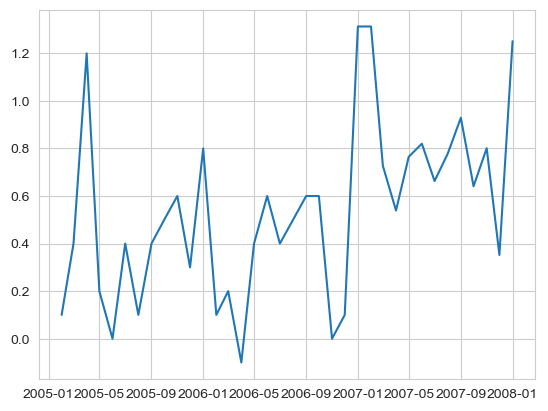

In [28]:
plt.plot(diff_y[:36])

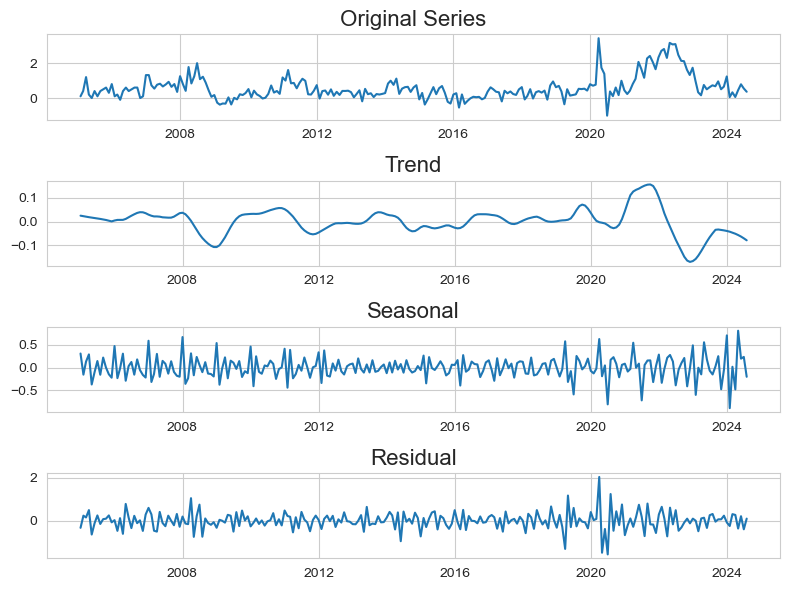

In [29]:
decomposition = STL(differencing(Y, 2))
result = decomposition.fit()
seasonal, trend, resid = result.seasonal, result.trend, result.resid
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(diff_y)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(plot_folder, 'Seasonality_decomposition.png'))

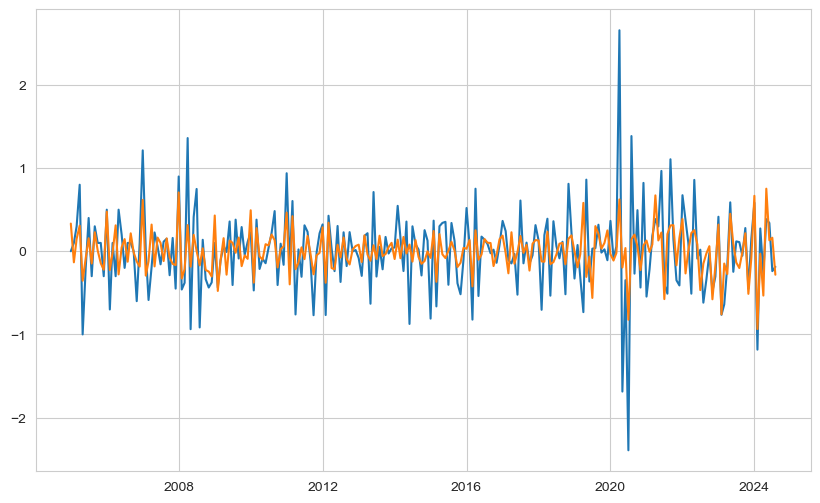

In [30]:
prediction = seasonal + trend
plt.figure(figsize=(10, 6))
plt.plot(differencing(Y, 2))
plt.plot(prediction)
plt.savefig(os.path.join(plot_folder, 'SLT_prediction.png'))

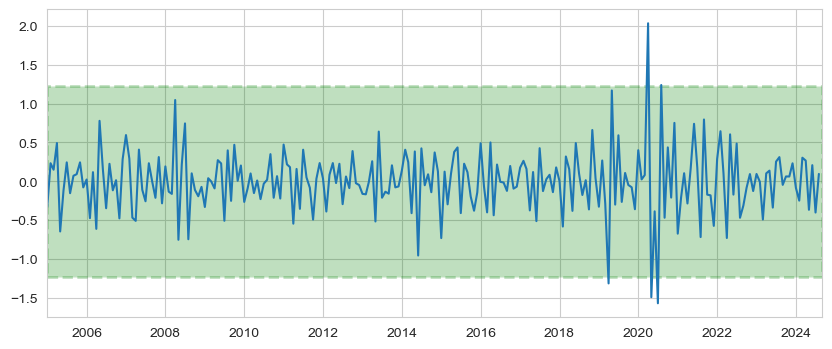

In [31]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2005,1,1), datetime(2024,9,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2005,1,1), datetime(2024,9,1))

plt.savefig(os.path.join(plot_folder, 'Anamolies_detection.png'))

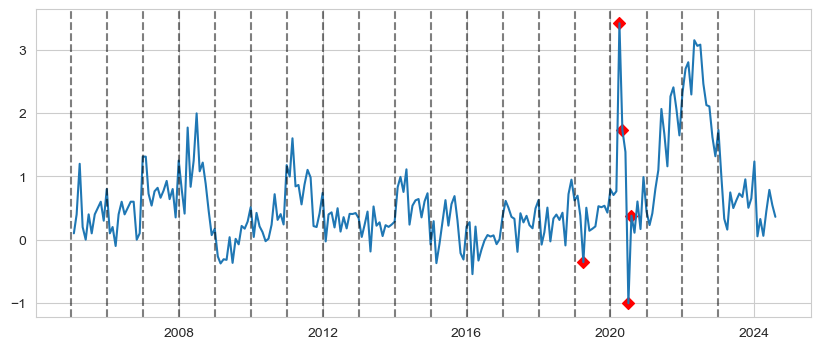

In [32]:
anomalies = diff_y[(resid < lower) | (resid > upper)]

plt.figure(figsize=(10,4))
plt.plot(diff_y)
for year in range(2005,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.values, color='r', marker='D')
plt.savefig(os.path.join(plot_folder, 'Anamolies_points.png'))

### AR order and MA order

We will perform ACF and PACF to determine the Autoregressive term and Moving Average term.

/tmp/ipykernel_90818/4003770003.py:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/tmp/ipykernel_90818/4003770003.py:6: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



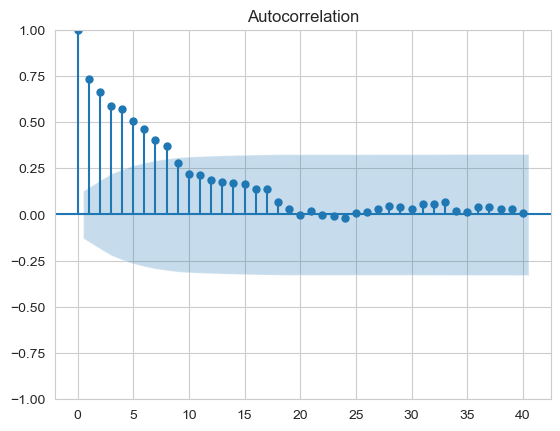

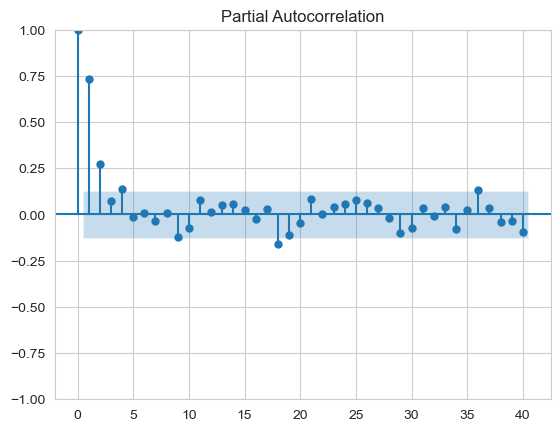

In [33]:
acf = plot_acf(diff_y, lags=40)
acf.savefig(os.path.join(plot_folder, 'ACF.png'))
acf.show()
pacf = plot_pacf(diff_y, lags=40)
pacf.savefig(os.path.join(plot_folder, 'PACF.png'))
pacf.show()

So MA term should be 9 and AR term should be 5

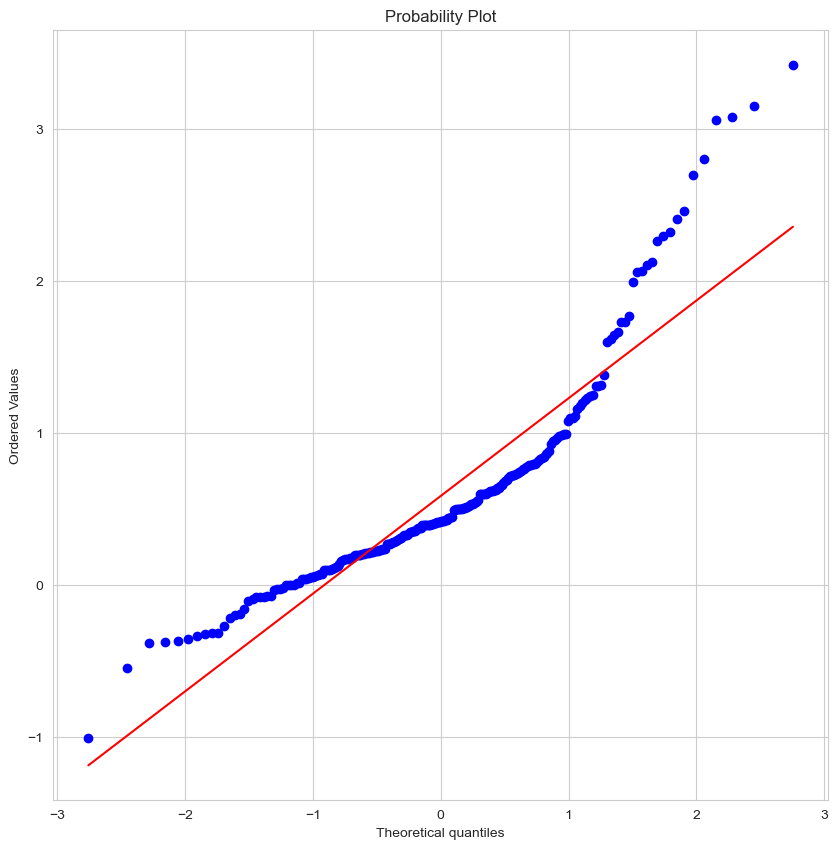

In [34]:
from scipy.stats import probplot


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
probplot(differencing(Y, 1), plot=ax, dist='norm')
plt.savefig(os.path.join(plot_folder, 'QQ_plot_of_CPI.png'))
# scaler = StandardScaler()


# standard_Y

In [35]:
stat, pvalues = stats.shapiro(differencing(Y, 2))
pvalues

3.679224607707663e-08

In [36]:
diff_y[8:]

DATE
2005-10-01    0.500
2005-11-01    0.600
2005-12-01    0.300
2006-01-01    0.800
2006-02-01    0.100
              ...  
2024-04-01    0.061
2024-05-01    0.447
2024-06-01    0.787
2024-07-01    0.548
2024-08-01    0.361
Freq: MS, Name: Food and Beverages CPI (target), Length: 227, dtype: float64

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           63     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.40060D-01    |proj g|=  5.40922D-01

At iterate    5    f=  4.17741D-01    |proj g|=  3.20668D-01

At iterate   10    f=  4.13366D-01    |proj g|=  3.29810D-01

At iterate   15    f=  4.05797D-01    |proj g|=  5.47248D-01

At iterate   20    f=  3.94063D-01    |proj g|=  1.86265D-01

At iterate   25    f=  3.86456D-01    |proj g|=  7.70569D-02

At iterate   30    f=  3.81038D-01    |proj g|=  9.75819D-02

At iterate   35    f=  3.77090D-01    |proj g|=  2.61560D-01

At iterate   40    f=  3.73992D-01    |proj g|=  7.21895D-02

At iterate   45    f=  3.72218D-01    |proj g|=  1.04548D-01

At iterate   50    f=  3.70480D-01    |proj g|=  4.79008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                                      SARIMAX Results                                      
Dep. Variable:     Food and Beverages CPI (target)   No. Observations:                  221
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 9)   Log Likelihood                 -81.876
Date:                             Mon, 11 Nov 2024   AIC                            289.752
Time:                                     17:10:03   BIC                            500.919
Sample:                                 10-01-2005   HQIC                           375.110
                                      - 02-01-2024                                         
Covariance Type:                               opg                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Frozen Food Manufacturing PP

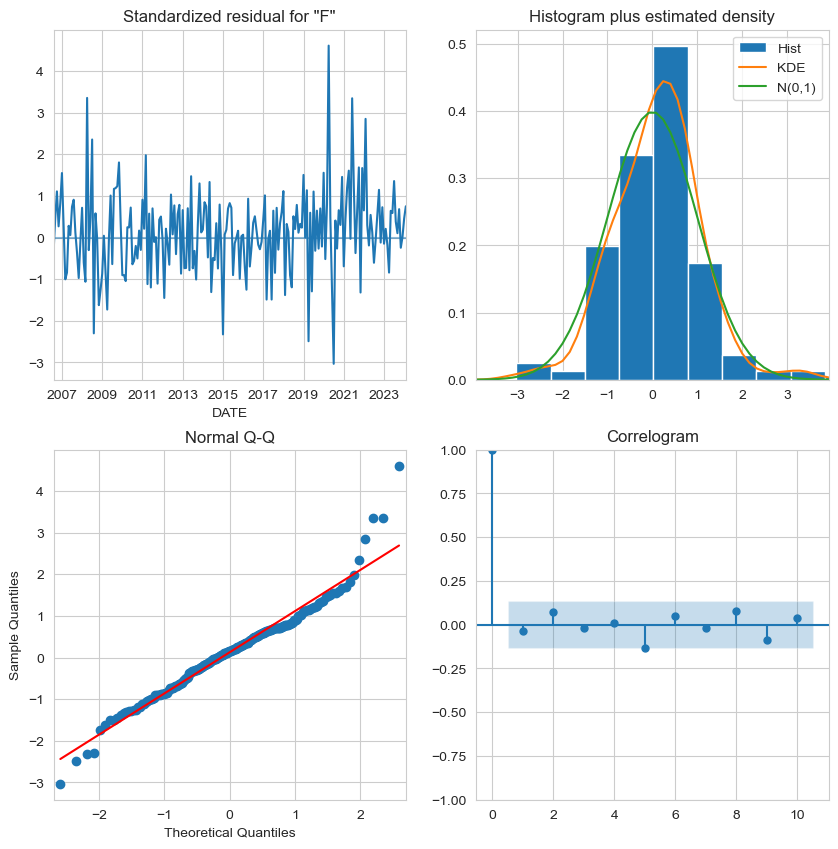

Model AIC:  289.75199774455075
Model BIC:  500.9190601535429
Balance:  211.16706240899214
MSE on dataset:  0.12824550281213512
MAE on dataset:  0.12824550281213512
MSE on test set:  0.32509791914592645
MAE on test set:  0.32509791914592645


In [114]:
start_time = diff_mean_only_X

SARIMAX_X_train = diff_mean_only_X.iloc[:-6,:]
SARIMAX_y_train = Y[9:-6]
SARIMAX_X_test = diff_mean_only_X.iloc[-6:,:]
SARIMAX_y_test = Y[-6:]

sarimax = SARIMAX(
    endog=SARIMAX_y_train, 
    exog=SARIMAX_X_train, 
    order=(0, 1, 0), #p,d,q order
    seasonal_order=(0, 1, 1, 9),
)
sarimax_results = sarimax.fit()

print(sarimax_results.summary())
sarimax_results.plot_diagnostics(figsize=(10,10))
plt.savefig(os.path.join(plot_folder, 'SARIMAX_diagnosis.png'))
plt.show()


SARIMAX_data_prediction = sarimax_results.predict(exog=SARIMAX_X_train.iloc[12:], start='10-01-2006')
SARIMAX_test_prediction = sarimax_results.predict(exog= SARIMAX_X_test, start='03-01-2024', end='08-01-2024')

print('Model AIC: ', sarimax_results.aic)
print('Model BIC: ', sarimax_results.bic)
print('Balance: ', np.abs(sarimax_results.aic - sarimax_results.bic))

print('MSE on dataset: ', mean_squared_error(SARIMAX_data_prediction, SARIMAX_y_train[12:]))
print('MAE on dataset: ', mean_squared_error(SARIMAX_data_prediction, SARIMAX_y_train[12:]))

print('MSE on test set: ', mean_squared_error(SARIMAX_test_prediction, SARIMAX_y_test))
print('MAE on test set: ', mean_squared_error(SARIMAX_test_prediction, SARIMAX_y_test))

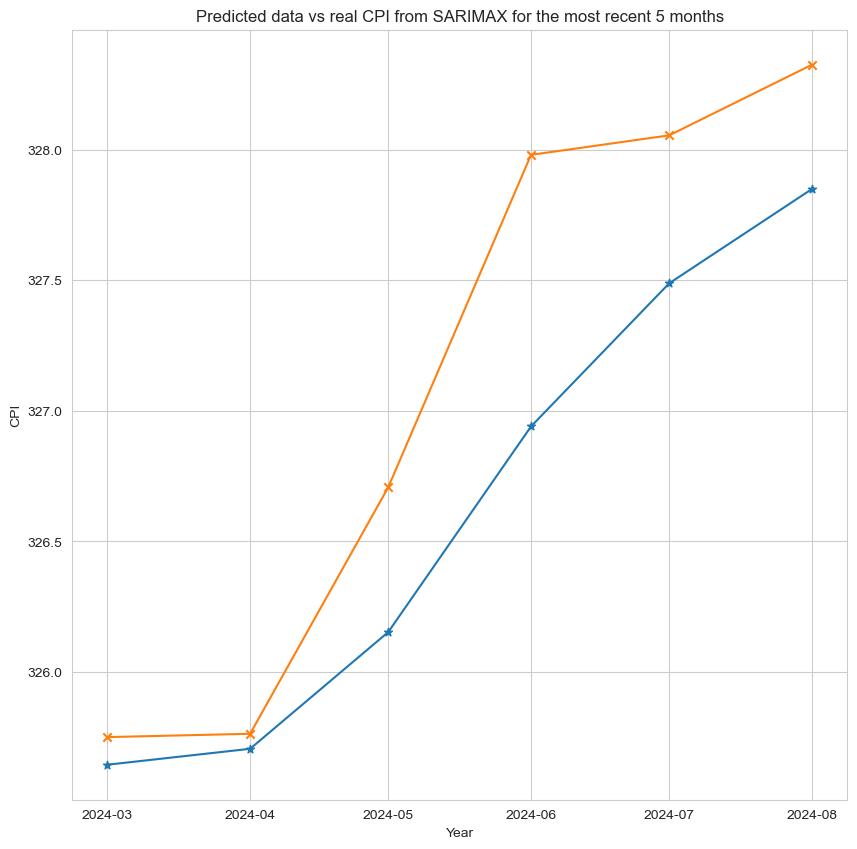

In [115]:
# y_predicted = results.predict(exog= SARIMAX_X_test, start='03-01-2024', end='08-01-2024')
plt.figure(figsize=(10,10))
plt.plot(SARIMAX_y_test[-7:])
plt.plot(SARIMAX_test_prediction)
plt.scatter(y=SARIMAX_y_test[-7:], x=SARIMAX_y_test[-7:].index, marker='*')
plt.scatter(y=SARIMAX_test_prediction, x=SARIMAX_y_test[-7:].index, marker='x')
plt.title('Predicted data vs real CPI from SARIMAX for the most recent 5 months')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(    
    os.path.join(plot_folder, 'SARIMAX_prediction.png')
)

In [39]:
import scipy.stats as stats

stat, pvalues = stats.shapiro(sarimax_results.resid)
print('Shapiro-Wilks test p-value: ', pvalues)

Shapiro-Wilks test p-value:  2.170036281882197e-31


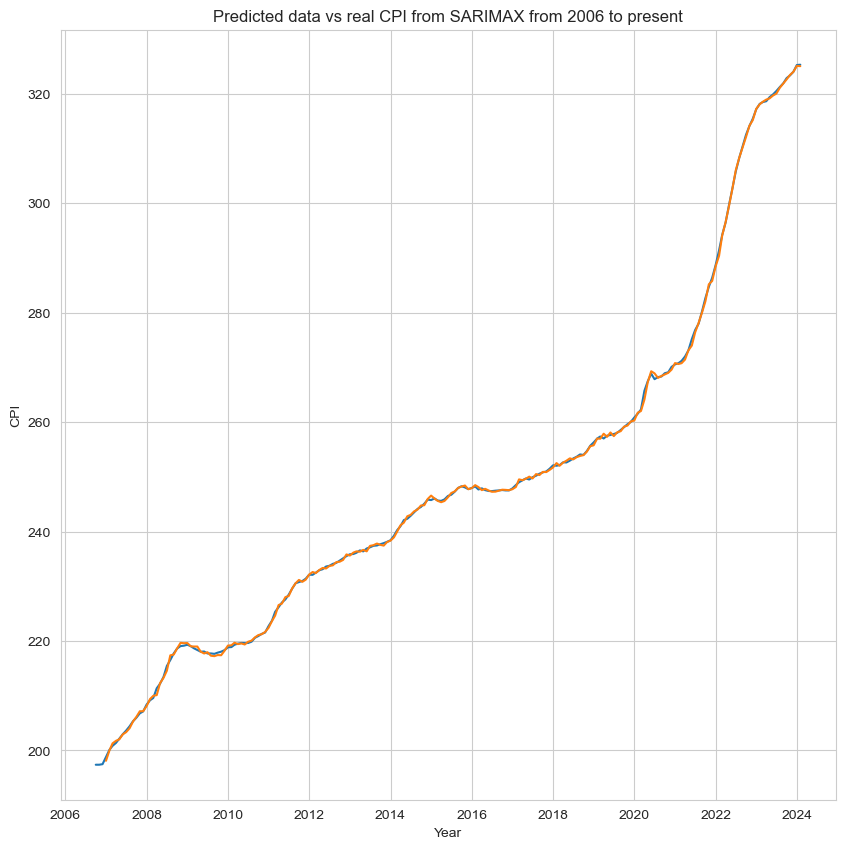

In [116]:
data_prediction = sarimax_results.predict(exog=SARIMAX_X_train.iloc[12:], start='01-01-2007')
plt.figure(figsize=(10,10))
plt.plot(SARIMAX_y_train.iloc[12:])
plt.plot(data_prediction)
plt.title('Predicted data vs real CPI from SARIMAX from 2006 to present')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(
    os.path.join(plot_folder, 'SARIMAX_prediction_whole_data.png')
)

### XGBoost 


In [83]:
tscv = TimeSeriesSplit(n_splits=10)
# diff_y = differencing(Y, 1)
new_Y = Y[1:]
split_index = -12
X_train = diff_mean_only_X[1:split_index]
X_test = diff_mean_only_X[split_index:]
y_train = diff_y[9:split_index]
y_test = diff_y[split_index:]


param_grid = {
    'n_estimators': [500, 1000],     # Number of trees
    'learning_rate': [0.01],  # Step size shrinkage
    'subsample': [0.5, 0.8, 1.0],             # Fraction of samples for training each tree
    'colsample_bytree': [0.5, 0.8, 1.0],      # Fraction of features for each tree,
}


# Define MSE as the scoring metric
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    scoring={'MSE': mse_scorer, 'MAE': mae_scorer},
    cv=tscv,
    n_jobs=-1,        # Use all available cores
    verbose=1,
    refit='MSE',
)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

split_mse_cols = [col for col in results.columns if 'split' in col and 'MSE' in col]
split_mae_cols = [col for col in results.columns if 'split' in col and 'MAE' in col]

best_index = results[results.rank_test_MSE == 1].index
mse_changes = -np.ravel(results.loc[best_index, split_mse_cols].values)
mae_changes = -np.ravel(results.loc[best_index, split_mae_cols].values)

print("Average MSE across folds:", np.mean(mse_changes))
print("Average MAE across folds:", np.mean(mae_changes))

test_mse = mean_squared_error(y_test, xgb.predict(X_test))
test_mae = mean_absolute_error(y_test, xgb.predict(X_test))
print("Test MSE: ", test_mse)
print("Test MAE: ", test_mse)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Average MSE across folds: 0.29666029413652606
Average MAE across folds: 0.38784804328554645
Test MSE:  0.19665916724633292
Test MAE:  0.19665916724633292


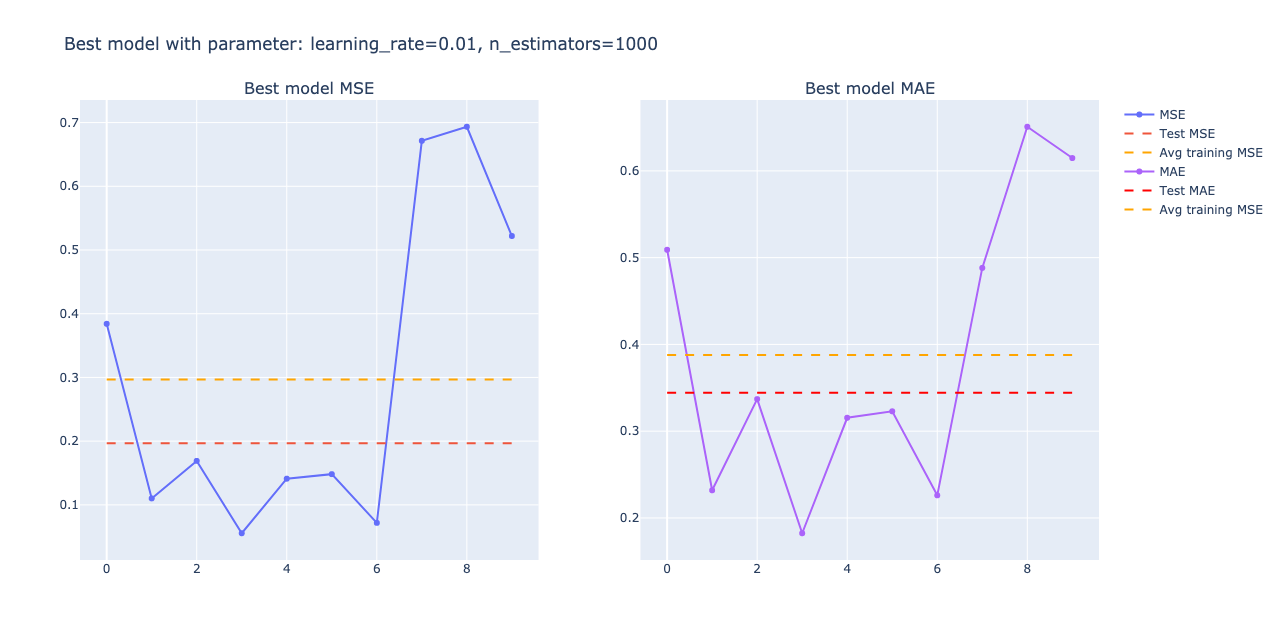

In [84]:
fig = make_subplots(1, 2, subplot_titles=["Best model MSE", "Best model MAE"])

fig.add_trace(
    go.Scatter(y=mse_changes, name='MSE'),
              row=1, 
              col=1)

fig.add_trace(
    go.Scatter(x=[0, len(mse_changes)-1], y=[test_mse, test_mse], name='Test MSE', mode='lines', line=dict(dash='dash')),
    row=1, 
    col=1
)

fig.add_trace(
    go.Scatter(x=[0, len(mse_changes)-1], y=[np.mean(mse_changes), np.mean(mse_changes)], name='Avg training MSE', mode='lines', line=dict(dash='dash', color='orange')),
    row=1, 
    col=1
)


fig.add_trace(
    go.Scatter(y=mae_changes, name='MAE'), 
              row=1, 
              col=2)

fig.add_trace(
    go.Scatter(x=[0, len(mae_changes)-1], y=[test_mae, test_mae], name='Test MAE', mode='lines', line=dict(dash='dash', color='red')),
    row=1, 
    col=2
)

fig.add_trace(
    go.Scatter(x=[0, len(mae_changes)-1], y=[np.mean(mae_changes), np.mean(mae_changes)], name='Avg training MSE', mode='lines', line=dict(dash='dash', color='orange')),
    row=1, 
    col=2
)

fig.update_layout(
    width=1280, 
    height=640, 
    title='Best model with parameter: ' + 
          # f"learning_rate={best_params['learning_rate']}, 
          f"learning_rate={best_params['learning_rate']}, "
          # f"max_depth={best_params['max_depth']}, "
          f"n_estimators={best_params['n_estimators']}",
)
fig.write_image(os.path.join(plot_folder, 'MSE_and_MAE_of_best_XGBoost_model.png'))
fig.show()

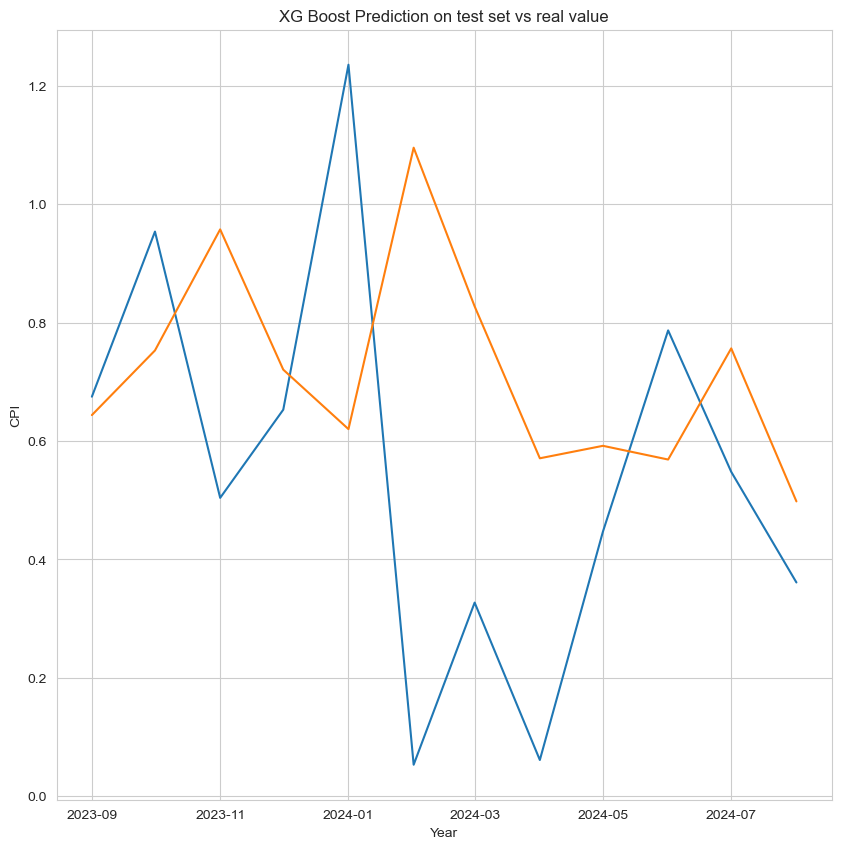

In [85]:
y_predicted = xgb.predict(X_test)

y_predicted = pd.Series(data=y_predicted, index=y_test.index)

plt.figure(figsize=(10,10))
plt.plot(y_test)
plt.plot(y_predicted)
plt.title('XG Boost Prediction on test set vs real value')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(os.path.join(plot_folder, 'XG_Boost_prediction'))
# y_test

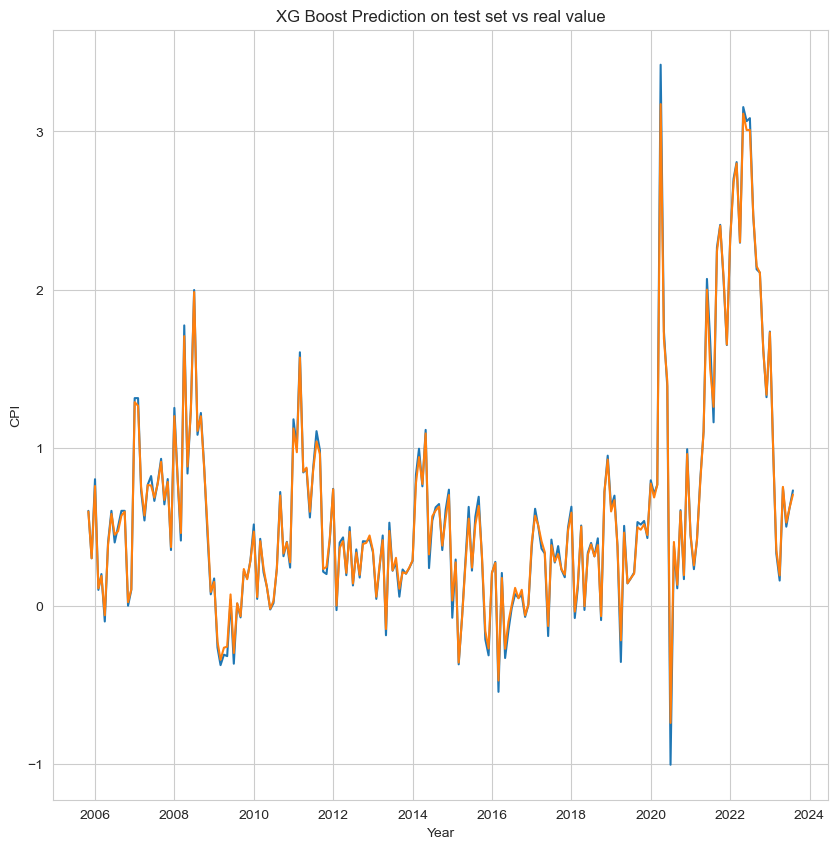

In [86]:
y_predicted = xgb.predict(X_train)

y_predicted = pd.Series(data=y_predicted, index=y_train.index)

plt.figure(figsize=(10,10))
plt.plot(y_train)
plt.plot(y_predicted)
plt.title('XG Boost Prediction on test set vs real value')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.savefig(os.path.join(plot_folder, 'XG_Boost_prediction'))
# y_test

Max difference 7.748604e-07


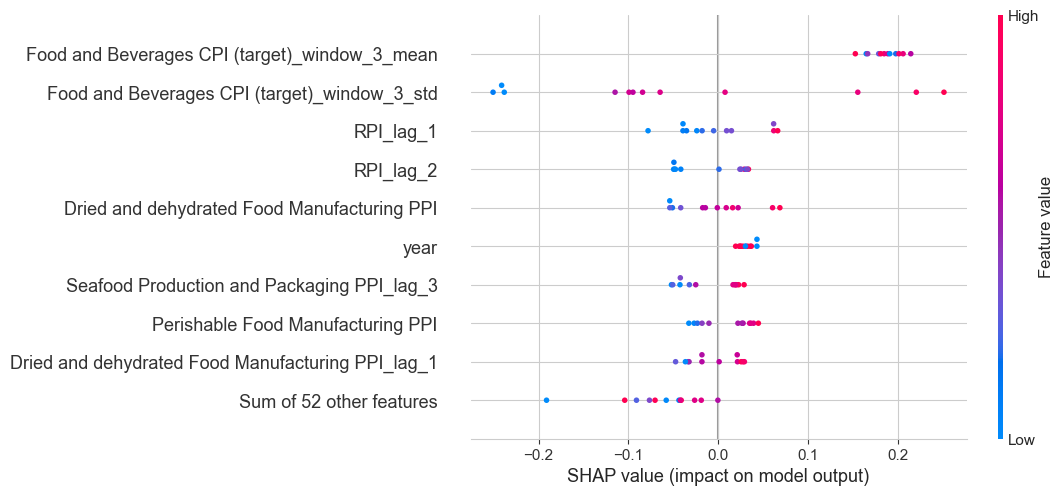

In [45]:
explainer = shap.TreeExplainer(xgb)
explanation = explainer(X_test)

y_predicted = xgb.predict(X_test)

shap_values = explanation.values
print("Max difference", np.abs(shap_values.sum(axis=1) + explanation.base_values - y_predicted).max())

fig = plt.figure(figsize=(10, len(X_test.columns) * 0.2)) 
shap.plots.beeswarm(explanation, show=False)
plt.savefig(os.path.join(plot_folder, 'SHAP_plot.png'), bbox_inches='tight')

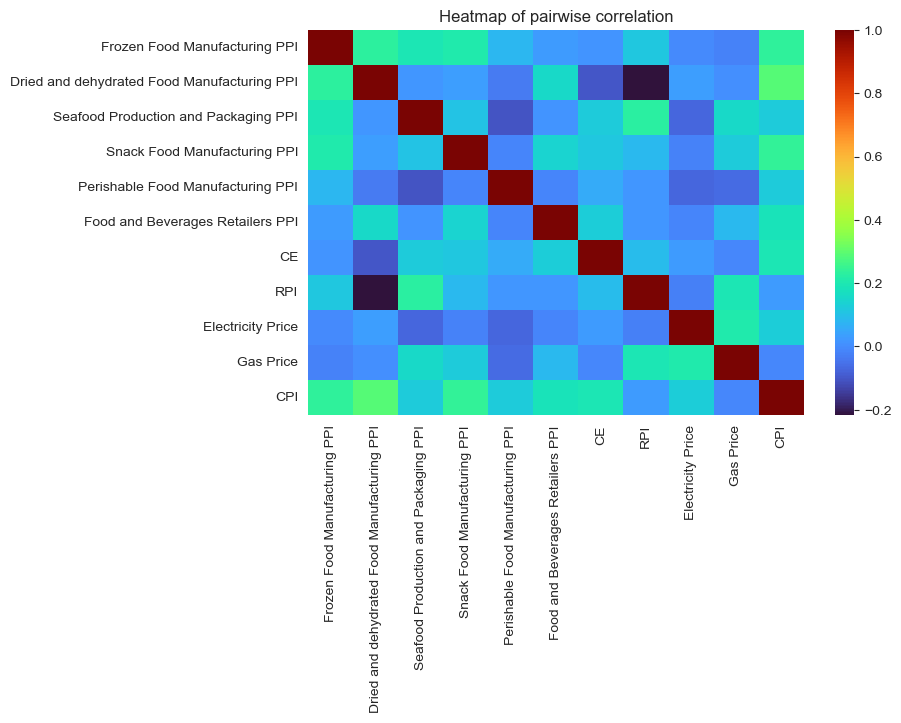

In [46]:
corr = diff_mean_only_df.corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap='turbo')
plt.title('Heatmap of pairwise correlation')
plt.savefig(os.path.join(plot_folder, 'Corr_heatmap.png'), bbox_inches='tight')

### LSTM Approach

In [89]:
scaler = MinMaxScaler()

def create_sequences(data, target, seq_length):
    # Scale the entire dataset and target
    data_scaled = scaler.fit_transform(data)
    target_scaled = scaler.fit_transform(target)
    print(len(data_scaled))
    X = []
    y = []
    
    for i in range(len(data_scaled) - seq_length):
        # Collect sequences across all features (except the last one for X)
        X.append(data_scaled[i:i+seq_length, :-1])
        # Target value from the last column at each sequence end
        y.append(target_scaled[i-1+seq_length])
    
    return np.array(X), np.array(y)

# Generate the sequences
sequenced_X, sequenced_y = create_sequences(diff_mean_only_X, pd.DataFrame(diff_y[9:], index=diff_y[9:].index), 12)

print("Shape of sequenced_X:", sequenced_X.shape)
print("Shape of sequenced_y:", sequenced_y.shape)

227
Shape of sequenced_X: (215, 12, 60)
Shape of sequenced_y: (215, 1)


In [90]:
X_train, X_test, y_train, y_test = train_test_split(sequenced_X, sequenced_y, test_size=0.2, shuffle=False)

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=81, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    # tf.keras.layers.LSTM(units=9, return_sequences=False),


    
    tf.keras.layers.LSTM(units=9, return_sequences=False),

    
    tf.keras.layers.Dense(units=9, activation='relu'),
    tf.keras.layers.Dense(1) 
])


lstm.compile(optimizer='adam', loss='mse')
lstm.summary()

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 81)         │        46,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 9)              │         3,276 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,384 (192.91 KB)

 Trainable params: 49,384 (192.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1993
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 
Epoch 12/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 
Epoch 13/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 
Epoch 14/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 
Epoch 15/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0156 
Epoch 16/500
6/6 ━━━

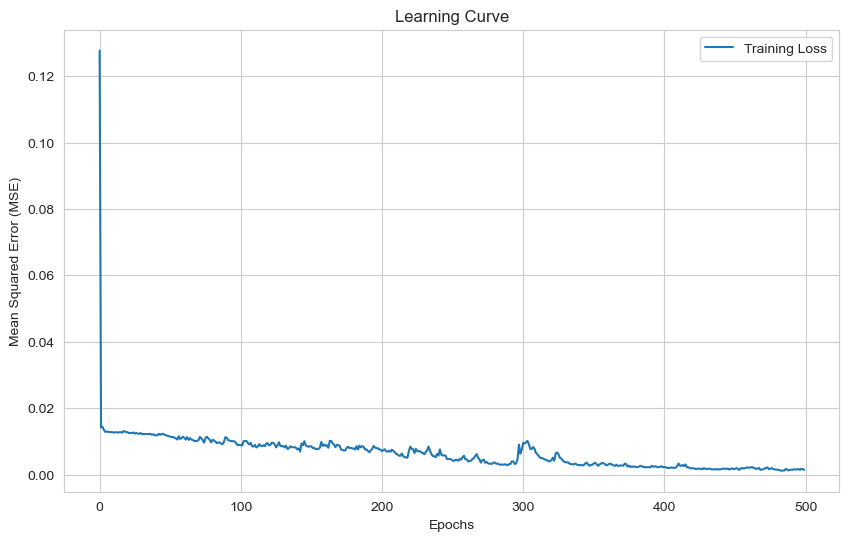

In [91]:
history = lstm.fit(X_train, y_train, epochs=500, verbose='auto')

y_predicted = lstm.predict(X_test)

mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predicted)

# Display additional results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
# print("R-squared (R²):", r2)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


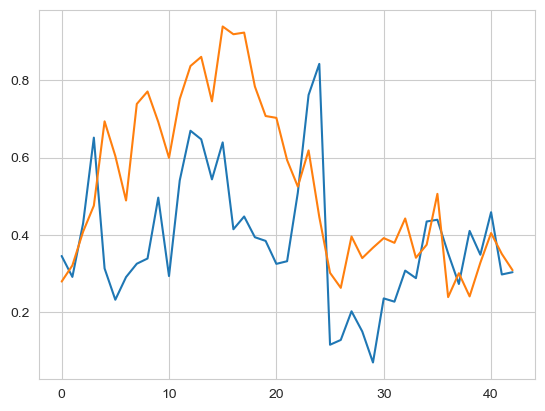

In [50]:
y_predicted = lstm.predict(X_test)
plt.plot(y_predicted)
plt.plot(y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


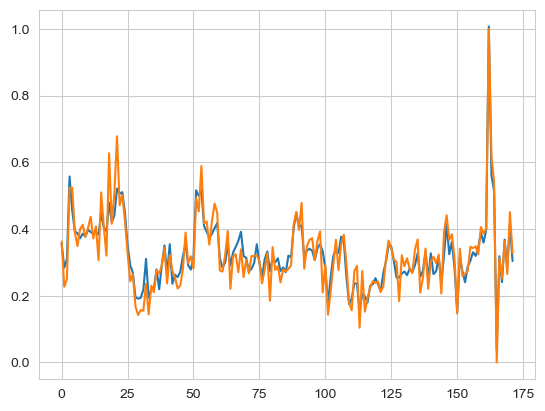

In [94]:
y_predicted = lstm.predict(X_train)
plt.plot(y_predicted)
plt.plot(y_train)

In [95]:
X_train

array([[[0.40167364, 0.40843956, 0.41605839, ..., 0.        ,
         0.        , 0.        ],
        [0.40167364, 0.45496418, 0.45255474, ..., 0.        ,
         0.        , 0.00246438],
        [0.40725244, 0.47357402, 0.44525547, ..., 0.        ,
         0.        , 0.00616096],
        ...,
        [0.41841004, 0.42239695, 0.39416058, ..., 0.05257526,
         0.1024664 , 0.02341164],
        [0.41841004, 0.41774449, 0.38686131, ..., 0.05257526,
         0.1024664 , 0.02686178],
        [0.39609484, 0.49683633, 0.40875912, ..., 0.05257526,
         0.1024664 , 0.03055836]],

       [[0.40167364, 0.45496418, 0.45255474, ..., 0.        ,
         0.        , 0.00246438],
        [0.40725244, 0.47357402, 0.44525547, ..., 0.        ,
         0.        , 0.00616096],
        [0.43514644, 0.41774449, 0.32116788, ..., 0.05257526,
         0.1024664 , 0.0096111 ],
        ...,
        [0.41841004, 0.41774449, 0.38686131, ..., 0.05257526,
         0.1024664 , 0.02686178],
        [0.3

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


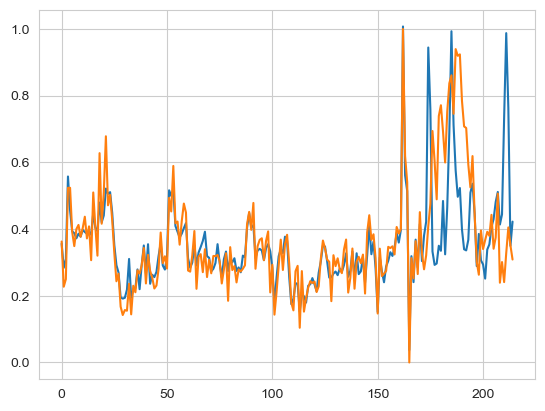

In [99]:
plt.plot(lstm.predict(sequenced_X))
plt.plot(sequenced_y)

In [126]:
SARIMAX_data_prediction

DATE
2006-10-01    196.903604
2006-11-01    197.279885
2006-12-01    197.131030
2007-01-01    198.119233
2007-02-01    200.011963
                 ...    
2023-10-01    322.633208
2023-11-01    323.462188
2023-12-01    324.024551
2024-01-01    325.104138
2024-02-01    325.055106
Freq: MS, Name: predicted_mean, Length: 209, dtype: float64

In [122]:
SARIMAX_result = pd.concat([SARIMAX_data_prediction, SARIMAX_test_prediction])

In [135]:
xgb_result_converted = [Y[10]]
xgb_result = xgb.predict(diff_mean_only_X)
for i in range(1, len(xgb_result)):
    xgb_result_converted.append(xgb_result[i] + xgb_result_converted[i - 1])

ML_prediction = pd.DataFrame(index= diff_mean_only_X.index)
ML_prediction['SARIMAX'] = SARIMAX_result
ML_prediction['XGBoost'] = xgb_result_converted
ML_prediction['CPI'] = Y.iloc[10:]
# ML_prediction['LSTM'] = lstm.predict()

ML_prediction.iloc[12:,:].to_csv(os.path.join(data_folder, 'ML_Prediction.csv'))

/tmp/ipykernel_90818/4050978727.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [136]:
ML_prediction.iloc[12:,:].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2006-10-01 to 2024-08-01
Freq: MS
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SARIMAX  215 non-null    float64
 1   XGBoost  215 non-null    float64
 2   CPI      215 non-null    float64
dtypes: float64(3)
memory usage: 6.7 KB


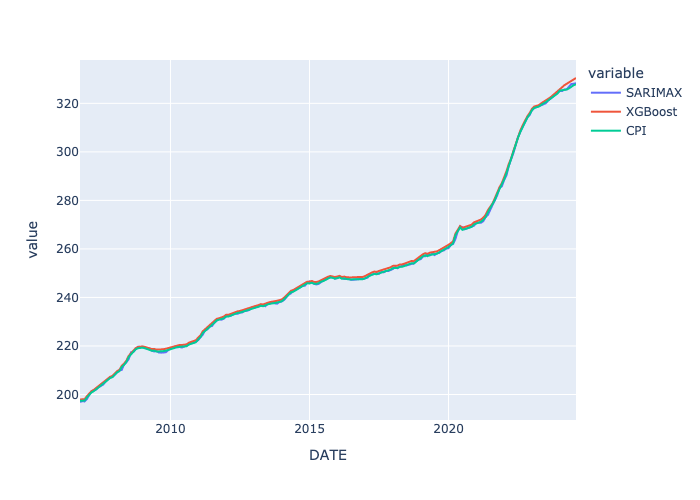

In [137]:
px.line(ML_prediction.iloc[12:,:])